# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [1102]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [1103]:
interaction_mean = df.groupby('email')['article_id'].count().mean()
print('In average a user is interacting {:.2f} times with articles.'.format(interaction_mean))

In average a user is interacting 8.93 times with articles.


In [1104]:
article_interactions = df.groupby(['email','article_id']).size().reset_index(name='counts')
unique_interactions = article_interactions.groupby('email').count()
print('In average a user is interacting with {:.2f} different articles.'.format(unique_interactions.article_id.mean()))

In average a user is interacting with 6.54 different articles.


Appearently a user interacting 3 times with the same article shall count as 3 interactions!

In [1105]:
import seaborn as sns
sns.set()

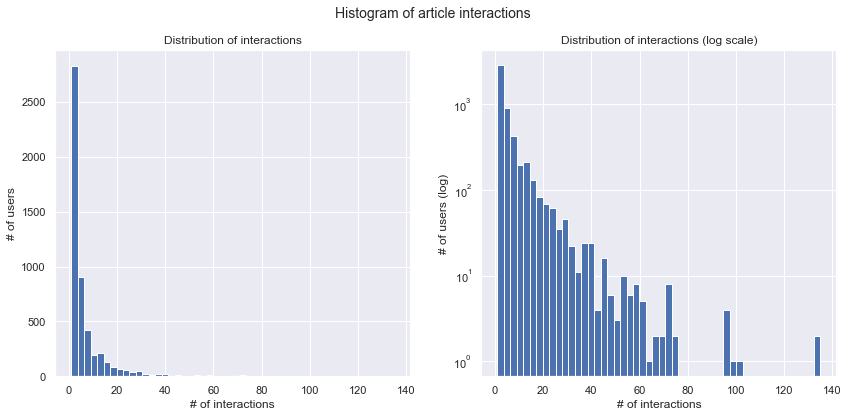

In [1106]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
ax1.hist(article_interactions.groupby('email')['article_id'].count(), bins=50)
ax1.set_xlabel('# of interactions')
ax1.set_ylabel('# of users')
ax1.set_title('Distribution of interactions')
ax2.hist(article_interactions.groupby('email')['article_id'].count(), bins=50)
ax2.set_xlabel('# of interactions')
ax2.set_yscale('log')
ax2.set_ylabel('# of users (log)')
ax2.set_title('Distribution of interactions (log scale)')
plt.suptitle('Histogram of article interactions', fontsize=14)
plt.show()

In [1107]:
# Fill in the median and maximum number of user_article interactios below

# 50% of individuals interact with 3 number of articles or fewer.
median_val = np.quantile(unique_interactions['article_id'], .5)
# The maximum number of user-article interactions by any 1 user is 135.
max_views_by_user = np.max(df.groupby('email').count()['article_id'])

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [1108]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [1109]:
# Find and explore duplicate articles
duplicates = df_content.duplicated(subset='article_id')
print('There are {} duplicates in the dataframe:'.format(duplicates.sum()))
df_content[duplicates]

There are 5 duplicates in the dataframe:


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [1110]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)
df_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1037 non-null object
doc_description    1048 non-null object
doc_full_name      1051 non-null object
doc_status         1051 non-null object
article_id         1051 non-null int64
dtypes: int64(1), object(4)
memory usage: 49.3+ KB


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [1111]:
unique_articles = len(df['article_id'].unique()) # The number of unique articles that have at least one interaction
total_articles = len(df_content['article_id'].unique()) # The number of unique articles on the IBM platform
unique_users = len(df[df['email'].isna() == False]['email'].unique()) # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

In [1112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [1113]:
df.groupby('article_id').count().sort_values('title', ascending=False).head(3)

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671


In [1114]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [1115]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [1116]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [1117]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = list()
    for element in df.groupby('article_id').count().sort_values('title', ascending=False).head(n).index:
        top_articles.append(df[df['article_id'] == element].iloc[0,1])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook a
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    top_articles = list()
    for element in df.groupby('article_id').count().sort_values('title', ascending=False).head(n).index:
        top_articles.append(df[df['article_id'] == element].iloc[0,:].article_id)
 
    return top_articles # Return the top article ids

In [1118]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [1119]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [1120]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    df_pivot = df[['article_id','user_id']].pivot_table(columns=['article_id'], 
                                                        index=['user_id'], aggfunc='size', fill_value=0)
    user_item = df_pivot.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [1121]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [1122]:
# Do one more test
assert len(df[df['user_id'] == 20]) ==  user_item.sum(axis=1)[20], "User 20 has seen 3 movies!"

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [1123]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dot_product = user_item[user_item.index == user_id].dot(user_item.T).iloc[0,:]
    
    # sort by similarity
    sorted_users = dot_product.sort_values(ascending=False).index

    # create list of just the ids
    sorted_users = list(sorted_users)
   
    # remove the own user's id
    sorted_users.remove(user_id)
    most_similar_users = sorted_users
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [1124]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [1125]:
def movies_liked_by_user(user_id):
    user_x = user_item[user_item.index == user_id]
    return user_x.loc[:, user_x.apply(lambda x: x== 1).values.flatten()].columns.values

def intersection_of_lists(list1, list2):
    return set(list1).intersection(set(list2))

In [1126]:
# Compare movies for similar users and a random other
print('Common movies of user 1 and 3933: {}'.format(intersection_of_lists(movies_liked_by_user(1), 
                                                                          movies_liked_by_user(3933))))
print('Common movies of user 1 and 2: {}'.format(intersection_of_lists(movies_liked_by_user(1), 
                                                                       movies_liked_by_user(2))))

Common movies of user 1 and 3933: {768.0, 390.0, 268.0, 525.0, 910.0, 1293.0, 1170.0, 1427.0, 1429.0, 1430.0, 1431.0, 1305.0, 668.0, 1052.0, 1436.0, 1183.0, 1439.0, 1185.0, 43.0, 310.0, 968.0, 329.0, 585.0, 1232.0, 1363.0, 981.0, 1368.0, 346.0, 732.0, 109.0, 494.0, 1391.0, 626.0, 1400.0, 1406.0}
Common movies of user 1 and 2: {1305.0, 1427.0}


In [1127]:
print('Common movies of user 46 and 4201: {}'.format(intersection_of_lists(movies_liked_by_user(46), 
                                                                           movies_liked_by_user(4201))))
print('Common movies of user 46 and 3: {}'.format(intersection_of_lists(movies_liked_by_user(46), 
                                                                       movies_liked_by_user(3))))

Common movies of user 46 and 4201: {2.0, 1162.0, 1164.0, 1293.0, 525.0, 1423.0, 1170.0, 1427.0, 1429.0, 1430.0, 1305.0, 1436.0, 1054.0, 1439.0, 1185.0, 933.0, 295.0, 1192.0, 43.0, 692.0, 184.0, 569.0, 316.0, 705.0, 962.0, 967.0, 1351.0, 76.0, 336.0, 1360.0, 1364.0, 1368.0, 89.0, 351.0, 224.0, 868.0, 109.0, 1393.0, 1014.0, 1017.0}
Common movies of user 46 and 3: {868.0, 1351.0, 1192.0, 43.0, 1293.0, 109.0, 1360.0, 1429.0, 1436.0}


Both tests suggest, that the similarity calculation looks good.

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [1128]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df.loc[df['article_id'].isin(article_ids), 'title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = list(user_item.loc[user_item.index == user_id, 
                                     user_item.iloc[user_item.index == user_id, :].squeeze() == 1].columns)
    
    return [str(id) for id in article_ids], get_article_names(article_ids) # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    articles_seen_by_user, _ = get_user_articles(user_id)
    article_recommendations = set()
    for neighbour_id in find_similar_users(user_id):
        if len(article_recommendations) > m:
            break
        articles_from_neighbour, _ = get_user_articles(neighbour_id) 
        article_recommendations = set(articles_from_neighbour).union(article_recommendations)
    recs = list(article_recommendations)[:m]
    
    return recs # return your recommendations for this user_id    

In [1129]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [1130]:
# Check Results
print('User 2 liked the following aricles:')
print(get_user_articles(2)[1])
print('And we recommend him these new articles')
get_article_names(user_user_recs(2, 10)) # Return 10 recommendations for user 1

User 2 liked the following aricles:
['healthcare python streaming application demo', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for naive bayes model', 'use r dataframes & ibm watson natural language understanding', 'build a python app on the streaming analytics service', 'using deep learning to reconstruct high-resolution audio']
And we recommend him these new articles


['classify tumors with machine learning',
 "a beginner's guide to variational methods",
 'transfer learning for flight delay prediction via variational autoencoders',
 'making data science a team sport',
 'pixiedust: magic for your python notebook',
 'this week in data science (april 18, 2017)',
 'markdown for jupyter notebooks cheatsheet',
 'environment statistics database - water',
 'what is smote in an imbalanced class setting (e.g. fraud detection)?',
 'get social with your notebooks in dsx']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [1131]:
def get_user_articles_df(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    DataFrame - a dataframe with the articles of the user and their total interactions
    
    '''
    
    articles = user_item.loc[user_item.index == user_id, 
                                         user_item.iloc[user_item.index == user_id, :].squeeze() == 1].columns
    articles_df = pd.DataFrame({'article_id': articles})
    article_interactions = df.groupby('article_id')['title'].count()
    interactions_df = pd.DataFrame({'num_interactions': article_interactions})
    combined_df = articles_df.join(interaction_df, on='article_id')
    
    return combined_df.sort_values('num_interactions', ascending=False)

In [1132]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # compute similarity of each user to the provided user
    dot_product = user_item[user_item.index == user_id].dot(user_item.T).iloc[0,:]
    user_ids = dot_product.index
    similarity_measure = dot_product/dot_product.max()
    
    new_frame = pd.DataFrame({'neighbor_id': user_ids, 'similarity': similarity_measure})
    
    interactions = df.groupby('user_id')['article_id'].count()
    new_frame = new_frame.join(interaction_df, on='user_id')
    new_frame.set_index('neighbor_id', inplace=True)
    
    neighbors_df = new_frame.sort_values(['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df[1:] # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    articles_seen_by_user, _ = get_user_articles(user_id)
    article_recommendations = set()
    neighbors = get_top_sorted_users(20)
    for index, row in neighbors.iterrows():
        if len(article_recommendations) > m:
            break
        articles_from_neighbour = get_user_articles_df(neighbour_id) 
        for _, article_row in articles_from_neighbour.iterrows():
            if len(article_recommendations) > m:
                break
            article_recommendations.add(article_row.article_id)
    recs = list(article_recommendations)
    rec_names = get_article_names(recs)
        
    return recs, rec_names

In [1133]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[131.0, 295.0, 362.0, 409.0, 1163.0, 656.0, 693.0, 213.0, 665.0, 28.0, 223.0]

The top 10 recommendations for user 20 are the following article names:
['dsx: hybrid mode', 'using github for project control in dsx', 'analyze open data sets with spark & pixiedust', 'simple graphing with ipython and\xa0pandas', 'better together: spss and data science experience', 'modeling energy usage in new york city', 'awesome deep learning papers', 'deep forest: towards an alternative to deep neural networks', 'get social with your notebooks in dsx', 'using bigdl in dsx for deep learning on spark', 'deep learning achievements over the past year ']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [1134]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).index[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).index[9] # Find the 10th most similar user to user 131

In [1135]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Answer** <br>
We could only use the ranked based methods (e.g. get_top_articles) because we have no way of comparing our new user to the existing users. It would probably be better to provide a knowledge based recommendation to the user instead of recommend the most popular movies without any filter.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [1136]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id) for id in get_top_article_ids(10)]

In [1137]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [1138]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ch0125\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ch0125\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ch0125\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [1139]:
# Create collection of unique articles with their titles
unique_articles = df.groupby('article_id').first()
unique_articles = unique_articles.loc[:, ['title']]

In [1140]:
# Create own tokenizer for adding lemmatization

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    '''
    Tokenizes text and adds lemmatization
    '''
    
    # normalize case and remove punctuation
    text = re.sub(r"[^\w]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Remove tokens that are to short
    tokens = [token for token in tokens if not len(token) < 3]

    return tokens

In [1141]:
# Create tfidf matrix with all tokenized text
vectorizer = TfidfVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(unique_articles.title.values)

tfidf_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_matrix.set_index(unique_articles.index, inplace=True)

In [1142]:
def make_newest_recs(number_of_recs=10):
    '''
    Simply recommends the newest articles for cases where we do not have any knowlege
    about our users
    
    INPUT:
    number_of_recs: Number of recommendations to return
    
    OUTPUT:
    The n newest articles (with id and name)
    '''
    newest_articles = df_content.sort_values('article_id', ascending=False).head(number_of_recs)['article_id'].values
    
    return newest_articles, get_article_names(newest_articles)

In [1143]:
def make_content_recs(words='', number_of_recs=10):
    '''
    Makes content based recommendations based on titles. Hereby uses
    the default vectorizer for lemmatization
    
    INPUT:
    words: one ore multiple content words to search for
    number_of_recs: the number of recommendations to return
    
    OUTPUT:
    A list with the article_ids
    
    '''
    
    if len(words) == 0 or words.isspace():
        return make_newest_recs(10)
    
    recommendations = dict()
    
    # For each search word
    for word in words.split(' '):
        
        # if the word is present in the columns
        if word in tfidf_matrix.columns:
            articles_with_word = tfidf_matrix[tfidf_matrix[word] > 0.0].sort_values(word, ascending=False)[word]
            
            # Add or update rating of article
            for index, score in articles_with_word.items():
                if index in recommendations:
                    recommendations[index] += score
                else:
                    recommendations[index] = score
                    
    # Sort the articles based on their rating                
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    
    # Return top n articles
    recommendet_articles = list()
    for article_id, score in sorted_recommendations:
        if len(recommendet_articles) > num_of_articles:
            break
        recommendet_articles.append(article_id)
    return recommendet_articles, get_article_names(recommendet_articles)

In [1144]:
# Test our content based search algorithm with a search
make_content_recs('notebook iot')

([12.0, 29.0, 373.0, 151.0, 528.0, 110.0, 665.0, 0.0, 855.0, 1336.0, 958.0],
 ['timeseries data analysis of iot events by using jupyter notebook',
  '10 tips on using jupyter notebook',
  'jupyter notebook tutorial',
  'working with notebooks in dsx',
  'experience iot with coursera',
  'learn basics about notebooks and apache spark',
  'enjoy python 3.5 in jupyter notebooks',
  'pixiedust: magic for your python notebook',
  'detect malfunctioning iot sensors with streaming analytics',
  'get social with your notebooks in dsx',
  'using dsx notebooks to analyze github data'])

In [1145]:
# Without any search term
make_content_recs()

(array([1050, 1049, 1048, 1047, 1046, 1045, 1044, 1043, 1042, 1041],
       dtype=int64),
 ['use ibm data science experience to read and write data stored on amazon s3',
  '1357    what i learned implementing a classifier from ...\nName: title, dtype: object',
  'jupyter notebooks with scala, python, or r kernels',
  'mapping points with folium',
  'a comparison of logistic regression and naive bayes ',
  'use iot data in streams designer for billing and alerts'])

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Answer**<br/>
My content based recommendation methods works by first building a tfidf matrix out of the titles of all articles. If a search with words is executed the algorithm builds a combined dictionary from all the ratings of the words in the corpus. If no search term is provided the mathod just recommends the most recent stories. <br/>
Note: <br/>
In the example above we can see that the articles with both words in the title are listed at the beginning ('timeseries data analysis of <font color='blue'>iot</font> events by using jupyter <font color='blue'>notebook</font>') and the articles with just one matching word are returned later ('using dsx <font color='blue'>notebooks</font> to analyze github data').

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [1146]:
# make recommendations for a brand new user
# Option 1: Most recent articles
print('New user option 1 (most recent articles): \n{}\n'.format(make_content_recs()[1]))
# Option 2: The user was visiting the ibm watson studio on the web,
# so there seems to be some clear interest and we recommend corresponding articles
print('New user option 2 (articles representing site): \n{}\n'.format(make_content_recs('ibm watson')[1]))

# make a recommendations for a user who only has interacted with article id '1427.0'
title_of_last_article = df[df['article_id'] == 1427.0].iloc[0, :]['title']
print('User who has only interacted with aritcle 1427.0: \n{}\n'.format(make_content_recs(title_of_last_article)[1][1:]))

New user option 1 (most recent articles): 
['use ibm data science experience to read and write data stored on amazon s3', '1357    what i learned implementing a classifier from ...\nName: title, dtype: object', 'jupyter notebooks with scala, python, or r kernels', 'mapping points with folium', 'a comparison of logistic regression and naive bayes ', 'use iot data in streams designer for billing and alerts']

New user option 2 (articles representing site): 
['ibm watson facebook posts for 2015', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'intents & examples for ibm watson conversation', 'use r dataframes & ibm watson natural language understanding', 'ibm watson machine learning: get started', 'pixiedust 1.0 is here! – ibm watson data lab', 'i am not a data scientist – ibm watson data lab', 'flightpredict ii: the sequel  – ibm watson data lab', 'share the (pixiedust) magic – ibm watson data lab – medium', 'introducing ibm watson studio ', 'analyze facebook data using 

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [1147]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [1148]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [1149]:
# Does the matrix has any missing values?
user_item_matrix.isna().any().any()

False

In [1150]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True)

In [1151]:
[print('{}: {}'.format(m, n.shape)) for n, m in zip([u, s, vt], ['U', 'S', 'V*'])]

U: (5149, 5149)
S: (714,)
V*: (714, 714)


[None, None, None]

**Provide your response here.**

**Answer:** <br/>
The difference is that we only have interactions and not ratings. This however does not hinder us from using SVD. Due to our approach we do not have to deal with missing values and don't need to implement FunkSVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

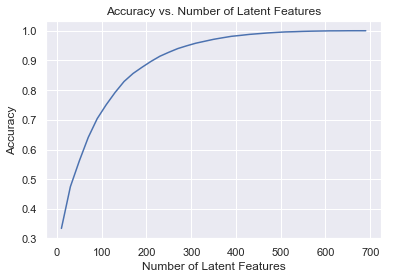

In [1152]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [1153]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    df_pivot = df_train[['article_id','user_id']].pivot_table(columns=['article_id'], 
                                                        index=['user_id'], aggfunc='size', fill_value=0)
    user_item_train = df_pivot.applymap(lambda x: 1 if x > 0 else 0)
    
    df_pivot = df_test[['article_id','user_id']].pivot_table(columns=['article_id'], 
                                                        index=['user_id'], aggfunc='size', fill_value=0)
    user_item_test = df_pivot.applymap(lambda x: 1 if x > 0 else 0)
    
    user_item_test = user_item_test[user_item_test.index.isin(user_item_train.index)]
    
    test_idx = df_test['user_id'].unique()
    test_arts = df_test['article_id'].unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [1161]:
# I did correct the project tests because the
# keys where obviously  wrong
#import project_tests as t
import importlib
importlib.reload(t)

<module 'project_tests' from 'c:\\source\\dsnd\\recommendations-with-ibm\\project_tests.py'>

In [1162]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [1163]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True)

In [1164]:
# Create U, S and V^T of test set by taking latent feaures of training
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
u_test.shape, vt_test.shape

((20, 4487), (714, 574))

In [1165]:
# Find subset of users and articles we can predict
common_users = set(user_item_train.index).intersection(set(user_item_test.index))
common_articles = set(user_item_train.columns).intersection(set(user_item_test.columns))
common_user_articles_df = user_item_test.loc[common_users, common_articles]
print(common_user_articles_df.shape)
common_user_articles_df.head()

(20, 574)


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
3968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1166]:
from tqdm import tqdm_notebook
from sklearn.metrics import fbeta_score

# Make predictions for increasing number of latent factors
num_latent_factors = np.arange(10, 711, 20)

train_errors, test_errors = [], []
train_fbeta_scores, test_fbeta_scores = [], []

# There is no harm in providing movies that do not much,
# therefore we make the beta > 1
beta_param = 1.5

# We have a heavy label imbalance therefore we use macro average
average_param = 'macro'

for k in tqdm_notebook(num_latent_factors):
    
    # Create subset of train U, S, V* and U_test, V*_test with only k latent features
    s_train_sub, u_train_sub, vt_train_sub = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_sub, vt_test_sub = u_test[:, :k], vt_test[:k, :]
    
    # Calculate dot product of training and testing set
    train_pred = np.around(np.dot(np.dot(u_train_sub, s_train_sub), vt_train_sub))
    test_pred = np.around(np.dot(np.dot(u_test_sub, s_train_sub), vt_test_sub))
    
    # Calculate testing and training error
    train_e = np.subtract(user_item_train, train_pred)
    test_e = np.subtract(common_user_articles_df.values, test_pred)
    
    # Calculate the beta score
    train_fbeta = fbeta_score(np.array(user_item_train).flatten(), 
                              np.array(train_pred).flatten(), beta=beta_param, average=average_param, labels=[0, 1.0])
    test_fbeta = fbeta_score(np.array(common_user_articles_df.values).flatten(), 
                             np.array(test_pred).flatten(), beta=beta_param, average=average_param, labels=[0, 1.0])
    
    # Collect errors / scores
    train_errors.append(np.sum(np.sum(np.abs(train_e))))
    test_errors.append(np.sum(np.sum(np.abs(test_e))))
    train_fbeta_scores.append(train_fbeta)
    test_fbeta_scores.append(test_fbeta)

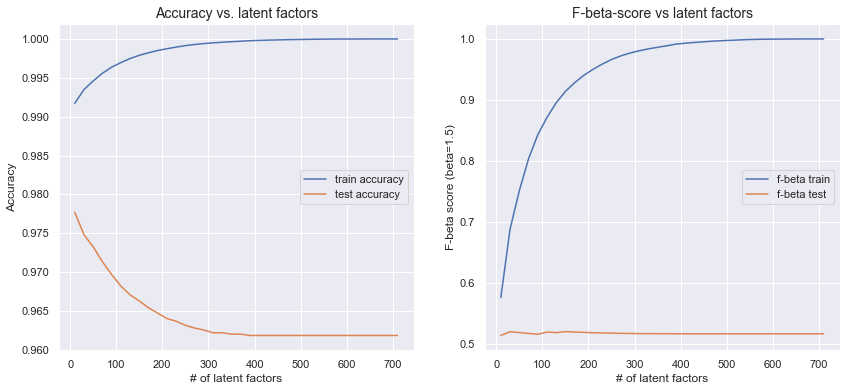

In [1167]:
# Calculate number of predictions
train_pred_n = user_item_train.shape[0] * user_item_train.shape[1]
test_pred_n = common_user_articles_df.shape[0] * common_user_articles_df.shape[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
plt.rc('')

# Visualize train and testing curve
ax1.plot(num_latent_factors, 1-np.array(train_errors)/train_pred_n)
ax1.plot(num_latent_factors, 1-np.array(test_errors)/test_pred_n)

ax1.set_xlabel('# of latent factors')
ax1.set_ylabel('Accuracy')

ax1.set_title('Accuracy vs. latent factors', fontsize=14)
ax1.legend(['train accuracy', 'test accuracy'])

# Visualize f-beta score
ax2.plot(num_latent_factors, train_fbeta_scores)
ax2.plot(num_latent_factors, test_fbeta_scores)

ax2.set_xlabel('# of latent factors')
ax2.set_ylabel('F-beta score (beta=1.5)')

ax2.set_title(r"F-beta-score vs latent factors", fontsize=14)
ax2.legend(['f-beta train', 'f-beta test'], loc='center right')

plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Answer:** <br/>
To effectively measure the performance of our recommendations we need to set up an A/B-Test. We could employ a (session) cookie based unit of diversion and separate the sessions of the users in a test group with the new recommendations and a control group with the old recommendations (with simple random sampling). Then we could measure the interactions per session, searches per session and session time as evaluation metrics and some invariant metrics (numbers of visitors). Only if the metrics of the test group would be significantly better the new algorithm should be deployed.
 
Notes on test performance:<br/>
We can clearly see that the while the training accuracy is successively increasing by adding more latent factors, the testing accuracy is only dropping. This is a clear sign of overfitting. It is possible that with too many latent factors we also consider user-item interactions that do not represent the user’s preferences very well.
We also tried to measure our performance with a f-beta score to put the emphasis more on recall. Though we can see a slight increase in score in the beginning, the performance of the predictions are still not convincing. 
I think there are several reasons for a less than exciting performance of our algorithm:
* We only measure the articles the user has interacted with. We do not have any indication that the user also liked the article or even started dive into at all.
* Compared to a movie recommendation system where the user preferences are expected to be varying not that much I expect the user-item interaction with articles to be more diverse. There might be different reason why a user visits the portal and the article he interacts with can as well be simply curiosity based or even randomly (see argument before).
* In my opinion the most read articles on such a site might also be heavily affected by volatile trends in the industry. Searches (or interactions) with articles on themes like ‘iot’ or ‘jupyter notebook’ might correlate with the according technology cycle. So our latent factory might as well just be catching temporal trends in the industry. For this reason our ranked based recommendations might be an option to consider.

Notes on improvement:<br/>
If we want to improve our algorithm or we have found that after our A/B-Tests the recommender is not performing better than before there would be several steps we could take:
* Collect more data (still a not very sophisticated but highly effective way in most cases)
* Implement a like/dislike (or even rating, but in this case I would suggest like/dislike because we don’t want to burden the user with a mental overhead of making a 1-10 decision) approach for the readers. I would expect this addition to be of great use for the collaborative-filtering based recommendations as well as ranked or content based methods. Even for non-registered users we could better recommend the liked articles instead of just showing the articles with most interactions
* Incorporate the time into our recommendations because we suspect (see above) the interactions of the users be influenced by technology trends.
* Extend the content-based approach by allowing the user to select preferences (technologies, subjects) as well as allowing the user to select things most viewed articles or just articles with the highest momentum
* Implement a method (for example with google trends) to catch technology trends and feed this trends as keyword to our content based method above

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [1168]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0